In [40]:
import os               # for path joins
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns
from PIL import Image

# torchvision is optional – only used to preview augmentations
try:
    import torchvision.transforms as T
    HAS_TORCHVISION = True
except ImportError:
    HAS_TORCHVISION = False

# basic seaborn style
sns.set_theme(style="ticks", font_scale=1.05)

In [41]:
# ---------------------------------------------------------------------------
# 1. CONFIGURATION
# ---------------------------------------------------------------------------

# project folder layout (adapt these two if your paths differ)
PROJECT_DIR = os.path.abspath('..')          # parent folder of the notebook
DATA_DIR    = os.path.join(PROJECT_DIR, 'data')

CSV_TRAIN = os.path.join(DATA_DIR, 'train.csv')
CSV_VAL   = os.path.join(DATA_DIR, 'val.csv')

# root folder that contains the raw images (data/raw/PlantVillage/…)
IMG_ROOT  = DATA_DIR

# sample sizes for heavy operations (you can change them)
SAMPLE_IMG_STATS   = 2_000   # how many images to measure size / channel stats
SAMPLE_GRID        =   12    # how many random images to display
SAMPLE_AUG_PREVIEW =    8    # how many images in the augmentation preview

In [42]:
# ---------------------------------------------------------------------------
# 2. LOAD THE CSV FILES
# ---------------------------------------------------------------------------

def load_csv(path):
    # Read a CSV and check it contains the expected columns.
    df = pd.read_csv(path)
    expected = {'filepath', 'species', 'disease'}
    if not expected.issubset(df.columns):
        raise ValueError(f"CSV {path} is missing one of {expected}")
    return df

train_df = load_csv(CSV_TRAIN)
val_df   = load_csv(CSV_VAL)

# add a column that tells us if the row is train or val
train_df['split'] = 'train'
val_df['split']   = 'val'

# put everything in one big DataFrame
full_df = pd.concat([train_df, val_df], ignore_index=True)

print('Train images:', len(train_df))
print('Val   images:', len(val_df))

Train images: 37571
Val   images: 9392


In [ ]:
# ---------------------------------------------------------------------------
# 3. RESOLVE IMAGE PATHS TO ABSOLUTE PATHS
# ---------------------------------------------------------------------------
# We make sure that all paths are absolute

def make_abs_path(rel_path):
    # if the path is already absolute (starts with "/"), keep it
    if os.path.isabs(rel_path):
        return rel_path
    # if is relative we add PROJECT_DIR
    if rel_path.startswith('data'):
        return os.path.join(PROJECT_DIR, rel_path)
    # otherwise assume it is relative to IMG_ROOT
    return os.path.join(IMG_ROOT, rel_path)

full_df['abs_path'] = full_df['filepath'].apply(make_abs_path)

In [44]:
# ---------------------------------------------------------------------------
# 4. CHECK FOR MISSING OR CORRUPT FILES
# ---------------------------------------------------------------------------
# a) missing files – the file does not exist on disk
missing_mask = ~full_df['abs_path'].apply(os.path.exists)  # True if file is missing
missing_files = full_df[missing_mask]
print('Missing files referenced in CSV:', len(missing_files))

# b) corrupt files – PIL cannot open them (we test at most 1 000 to save time)
check_paths = full_df['abs_path'].sample(n=min(1000, len(full_df)), random_state=0)
corrupt_paths = []
for p in check_paths:
    try:
        with Image.open(p) as im:
            im.verify()       # quick format check (no full decode)
    except Exception:
        corrupt_paths.append(p)
print('Corrupt images found in sample of 1 000:', len(corrupt_paths))

Missing files referenced in CSV: 0
Corrupt images found in sample of 1 000: 0


/var/folders/td/v7jn9s9n1rb36krxbncpn2mr0000gn/T/ipykernel_91597/808236695.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.values, y=counts.index,


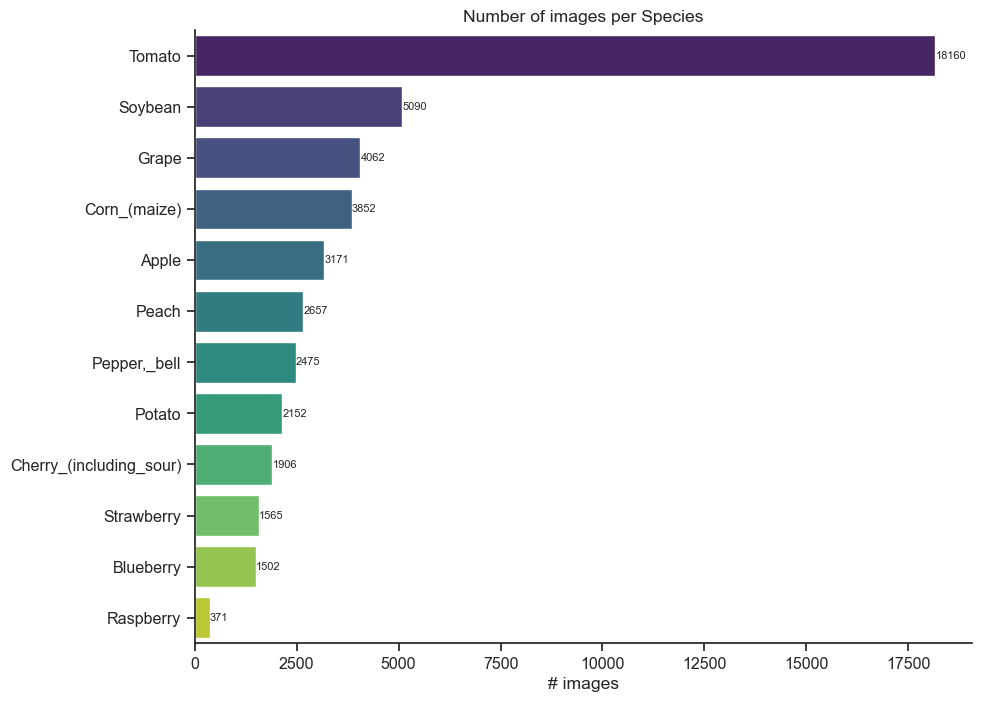

/var/folders/td/v7jn9s9n1rb36krxbncpn2mr0000gn/T/ipykernel_91597/808236695.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.values, y=counts.index,


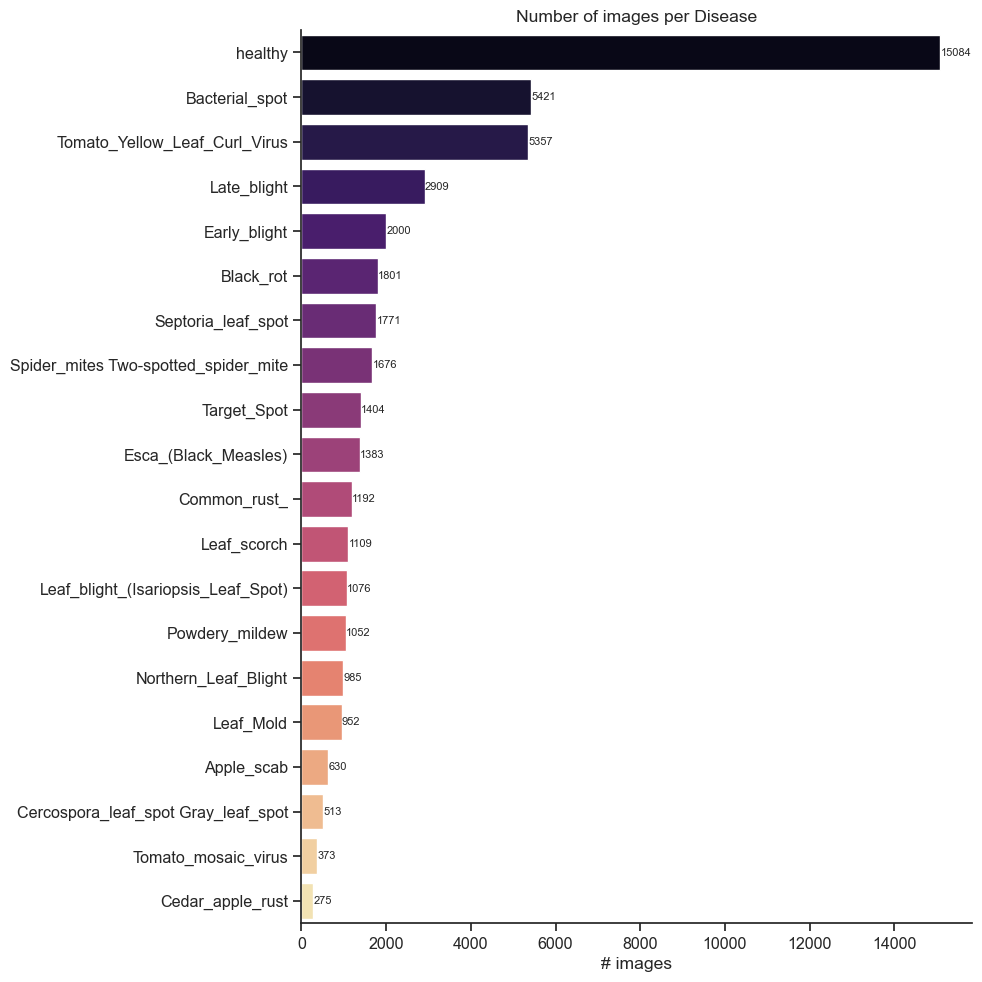

In [51]:
# ---------------------------------------------------------------------------
# 5. BAR CHARTS – HOW MANY IMAGES PER SPECIES / DISEASE
# ---------------------------------------------------------------------------
for label, column in [('Species', 'species'), ('Disease', 'disease')]:
    # count how many times each value appears
    counts = full_df[column].value_counts()

    # figure height grows with the number of categories (for readability)
    bar_height = 0.35 * len(counts) + 3   # simple formula that worked well
    plt.figure(figsize=(10, bar_height))

    sns.barplot(x=counts.values, y=counts.index,
                palette='viridis' if label == 'Species' else 'magma')

    plt.title(f'Number of images per {label}')
    plt.xlabel('# images')
    plt.ylabel('')

    # write the count number to the right of each bar
    for value, y in zip(counts.values, range(len(counts))):
        plt.text(value + 5, y, str(value), va='center', fontsize=8)

    sns.despine()
    plt.tight_layout()
    plt.show()

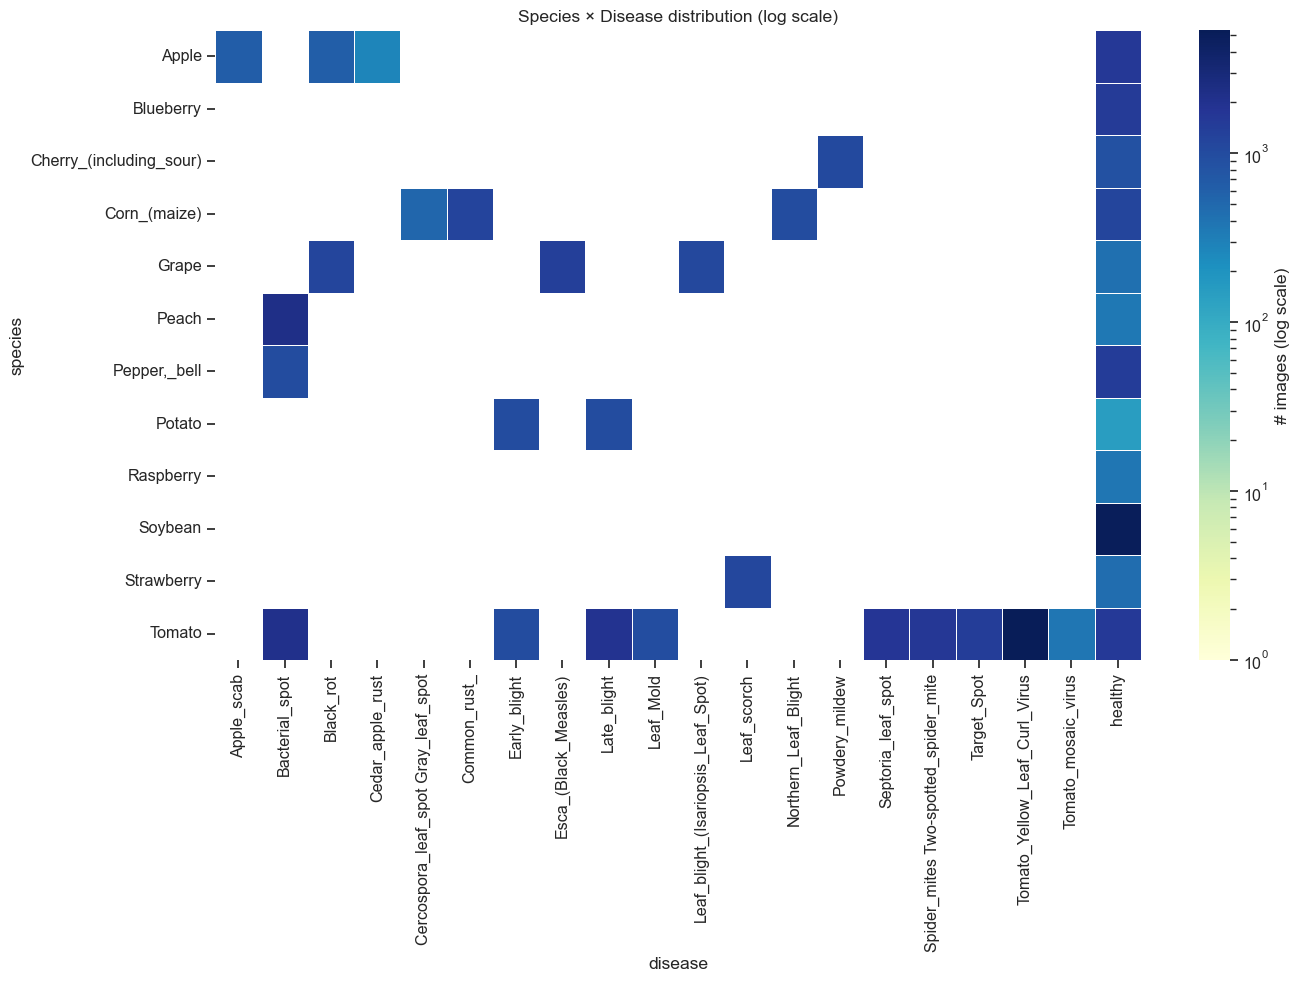

In [58]:
# ---------------------------------------------------------------------------
# 6. HEATMAP – SPECIES × DISEASE, LOG‑SCALE COLOR BAR
# ---------------------------------------------------------------------------
# create a pivot table where each cell = number of images for that combination
heat = (
    full_df
      .assign(count=1)                       # adds a column filled with 1
      .pivot_table(index='species',          # rows   → species
                   columns='disease',       # columns→ disease
                   values='count',
                   aggfunc='sum',
                   fill_value=0)            # 0 means that combo is absent
)

# height of figure based on number of species
fig_height = 0.5 * heat.shape[0] + 4
plt.figure(figsize=(14, fig_height))

sns.heatmap(
    heat,
    cmap='YlGnBu',
    norm=LogNorm(vmin=max(1, heat.values.min()), vmax=heat.values.max()),  # log colour scale
    cbar_kws={'label': '# images (log scale)'},
    linewidths=.4
)
plt.title('Species × Disease distribution (log scale)')
plt.tight_layout(); plt.show()

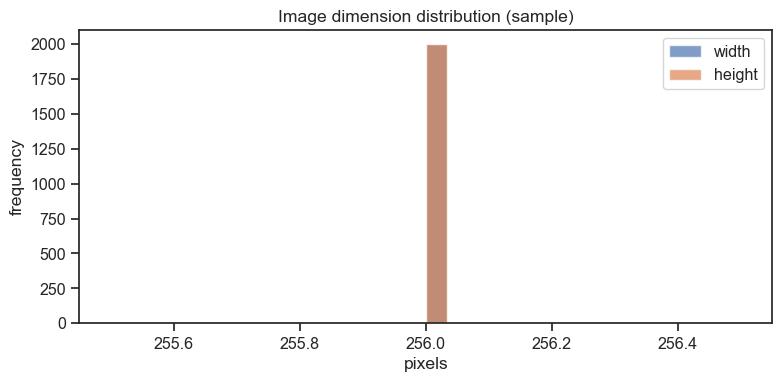

Median size: 256 × 256
Mean   size: 256 × 256


In [ ]:
# ---------------------------------------------------------------------------
# 7. IMAGE SIZE DISTRIBUTION (WIDTH AND HEIGHT HISTOGRAMS)
# ---------------------------------------------------------------------------
if SAMPLE_IMG_STATS > 0:
    size_sample = full_df['abs_path'].sample(n=min(SAMPLE_IMG_STATS, len(full_df)), random_state=1)
    all_sizes = [Image.open(p).size for p in size_sample]  # list of (width, height)
    widths  = [w for (w, h) in all_sizes]
    heights = [h for (w, h) in all_sizes]

    plt.figure(figsize=(8, 4))
    plt.hist(widths,  bins=30, alpha=0.7, label='width')
    plt.hist(heights, bins=30, alpha=0.7, label='height')
    plt.xlabel('pixels'); plt.ylabel('frequency'); plt.legend()
    plt.title('Image dimension distribution (sample)')
    plt.tight_layout(); plt.show()

    print('Median size:', int(np.median(widths)), '×', int(np.median(heights)))
    print('Mean   size:', int(np.mean(widths)),   '×', int(np.mean(heights)))

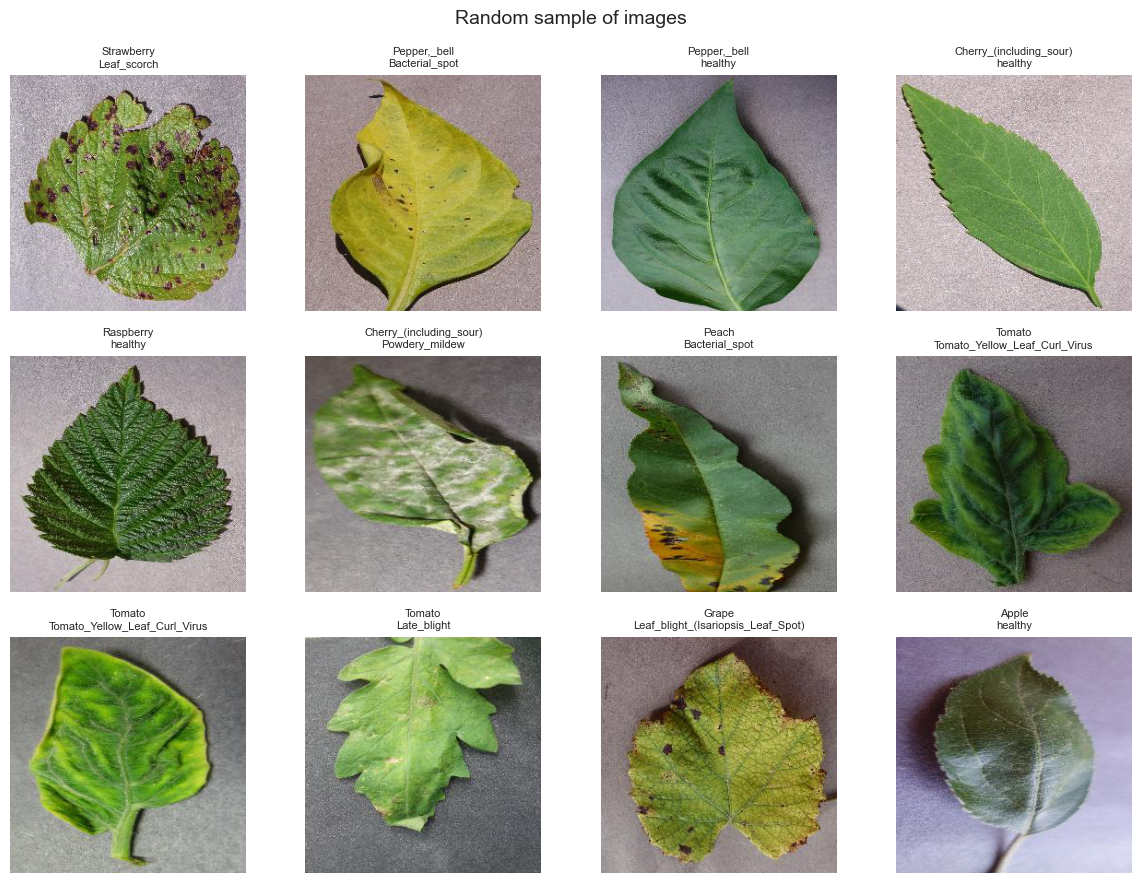

In [ ]:
# ---------------------------------------------------------------------------
# 8. RANDOM GRID OF SAMPLE IMAGES (HANDLES MISSING / CORRUPT)
# ---------------------------------------------------------------------------
GRID = SAMPLE_GRID
sample_df = full_df.sample(GRID, random_state=2)
cols = 4
rows = (GRID + cols - 1) // cols  # ceiling division
fig, axes = plt.subplots(rows, cols, figsize=(12, 3*rows))
axes = axes.flatten()

for ax, (_, row) in zip(axes, sample_df.iterrows()):
    path = row['abs_path']

    if not os.path.exists(path):
        ax.set_title('missing', fontsize=8)
        ax.axis('off')
        continue
    try:
        img = Image.open(path)
    except Exception:
        ax.set_title('corrupt', fontsize=8)
        ax.axis('off')
        continue

    ax.imshow(img)
    ax.set_title(f"{row['species']}\n{row['disease']}", fontsize=8)
    ax.axis('off')

# hide extra axes if GRID is not a multiple of cols
for ax in axes[GRID:]:
    ax.axis('off')

plt.suptitle('Random sample of images', fontsize=14)
plt.tight_layout(); plt.show()

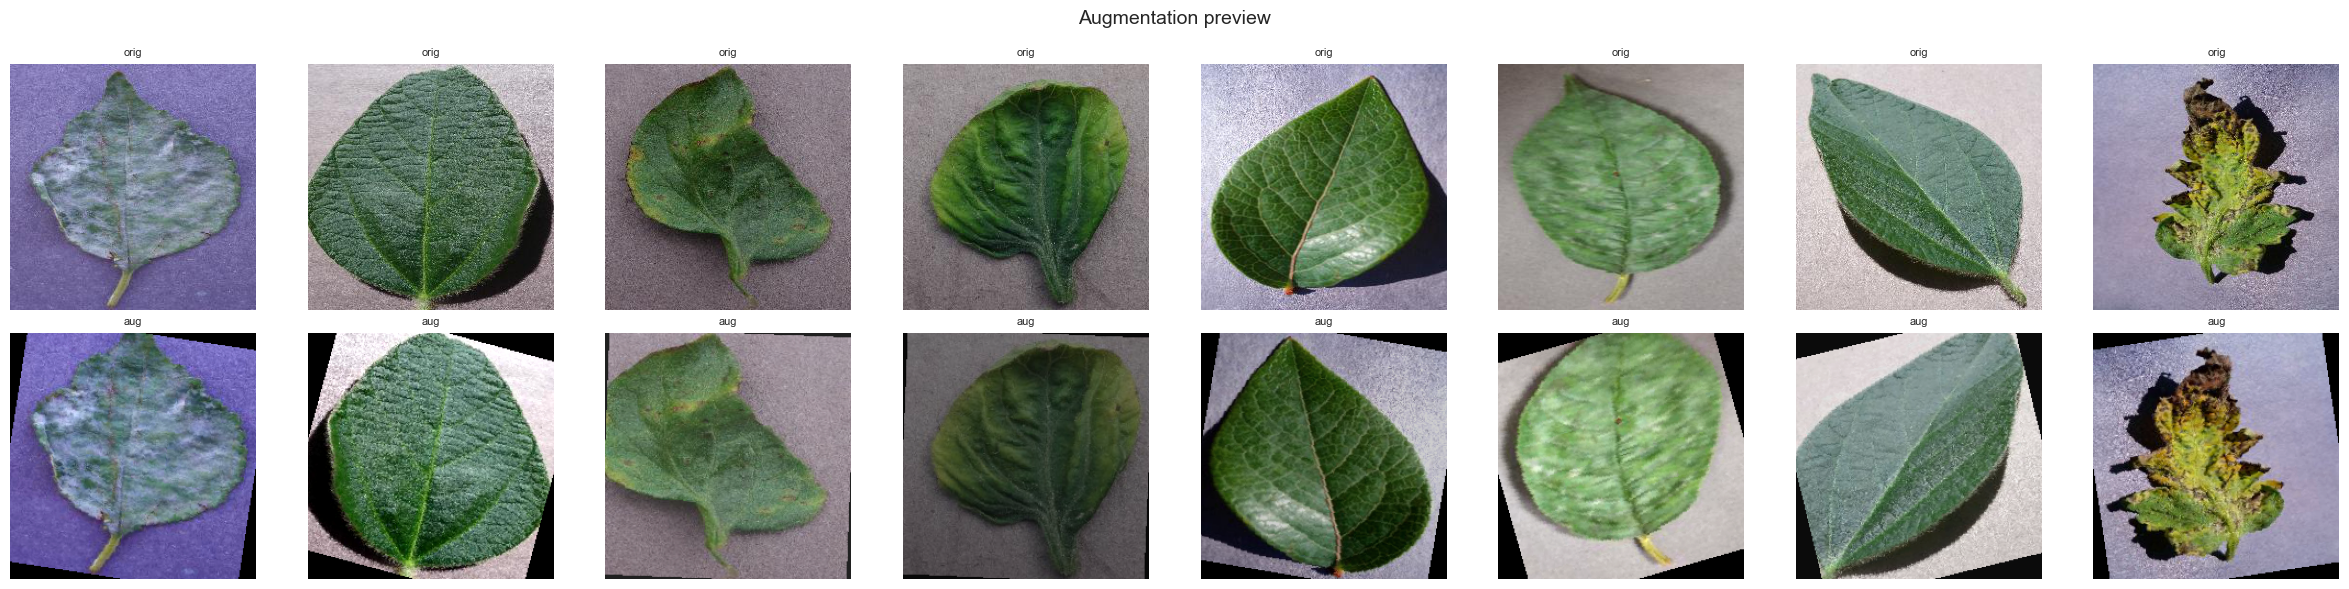

In [ ]:
# ---------------------------------------------------------------------------
# 9. SIMPLE AUGMENTATION PREVIEW (IF TORCHVISION IS INSTALLED)
# ---------------------------------------------------------------------------
if HAS_TORCHVISION and SAMPLE_AUG_PREVIEW > 0:
    transform = T.Compose([
        T.RandomResizedCrop(224, scale=(0.8, 1.0)),
        T.RandomHorizontalFlip(),
        T.RandomRotation(20),
        T.ColorJitter(                 # random brightness / contrast / saturation / hue
            brightness=0.3,
            contrast=0.3,
            saturation=0.3,
            hue=0.05
        ),
    ])

    prev_paths = full_df['abs_path'].sample(SAMPLE_AUG_PREVIEW, random_state=3)
    fig, axes = plt.subplots(2, SAMPLE_AUG_PREVIEW, figsize=(3*SAMPLE_AUG_PREVIEW, 6))

    for i, path in enumerate(prev_paths):
        img = Image.open(path).convert('RGB')
        axes[0, i].imshow(img);               axes[0, i].set_title('orig', fontsize=8); axes[0, i].axis('off')
        axes[1, i].imshow(transform(img));    axes[1, i].set_title('aug',  fontsize=8); axes[1, i].axis('off')

    plt.suptitle('Augmentation preview', fontsize=14)
    plt.tight_layout(); plt.show()
else:
    print('torchvision not installed – skipping augmentation preview')

In [ ]:
# ---------------------------------------------------------------------------
# 10. SAVE A SUMMARY CSV (IMAGES PER CLASS PER SPLIT)
# ---------------------------------------------------------------------------
summary = full_df.groupby(['species', 'disease', 'split']).size().unstack(fill_value=0)
summary_path = os.path.join(DATA_DIR, 'class_counts_summary.csv')
summary.to_csv(summary_path)
print('✔ Summary CSV saved to', summary_path)

print('EDA finished ✔')

✔ Summary CSV saved to /Users/zenotesta/Documents/GitHub/LeafAI/data/class_counts_summary.csv
EDA finished ✔
